In [1]:
import math
import random
import numpy as np
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

# =============================================================================
# Helper Functions (Algorithms 2 & 3)
# =============================================================================

def mq_encoder(x, epsilon, k):
    """
    [cite_start]Implements the Modulo Quantizer (MQ) encoder from Algorithm 2. [cite: 3]

    Args:
        x (float): The input real number to be quantized.
        epsilon (float): The lattice spacing parameter.
        k (int): The integer resolution parameter for the modulo operation.

    Returns:
        tuple[int, float]: A tuple containing:
            - w (int): The compressed integer message (tilde_z mod k).
            - tilde_z_val (float): The unbiased quantized value (epsilon * tilde_z).
    """
    # [cite_start]Step 1: Compute the indices of the two nearest lattice points [cite: 3]
    z_l = math.floor(x / epsilon)
    z_u = math.ceil(x / epsilon)

    # [cite_start]Step 2: Generate tilde_z through randomized unbiased quantization [cite: 3]
    # The probability 'p' ensures that E[epsilon * tilde_z] = x
    if z_l == z_u:
        tilde_z = z_l  # x is already on a lattice point
    else:
        p = (x / epsilon) - z_l
        if random.random() < p:
            tilde_z = z_u
        else:
            tilde_z = z_l
    
    # This is the high-resolution quantized value at the encoder
    tilde_z_val = epsilon * tilde_z

    # [cite_start]Step 3: Output the compressed message using the modulo operation [cite: 3]
    w = tilde_z % k
    return w, tilde_z_val

def mq_decoder(w, y, epsilon, k):
    """
    [cite_start]Implements the Modulo Quantizer (MQ) decoder from Algorithm 3. [cite: 3]

    Args:
        w (int): The compressed integer message from the encoder.
        y (float): The side information available at the decoder.
        epsilon (float): The lattice spacing parameter.
        k (int): The integer resolution parameter.

    Returns:
        float: The final reconstructed value.
    """
    # [cite_start]Step 1: Compute z_hat by finding the closest candidate to the side info y [cite: 3]
    # This solves the argmin problem: arg min |(z*k + w)*epsilon - y| over z in Z
    # which is equivalent to finding the integer z that is closest to:
    # (y/epsilon - w) / k
    z_hat = round((y / epsilon - w) / k)

    # [cite_start]Step 2: Reconstruct the integer index and output the final value [cite: 3]
    tilde_z_reconstructed = z_hat * k + w
    q_val = tilde_z_reconstructed * epsilon
    return q_val



In [2]:
# =============================================================================
# MODULO QUANTIZER (MQ) DEMO
# =============================================================================
print("-" * 50)
print("--- Modulo Quantizer (MQ) Demo ---")
print("-" * 50)

# --- Parameters ---
x = 10.73  # The value at the client (encoder)
y = 10.65  # Side information at the server (decoder)
k = 20     # Use log2(k) bits for the message
epsilon = 0.1 # Spacing of the fine lattice

# --- Check the Condition for Perfect Reconstruction (from Lemma 3.1) ---
delta_prime = abs(x - y)
condition_lhs = k * epsilon
condition_rhs = 2 * (epsilon + delta_prime)
condition_met = (condition_lhs >= condition_rhs)

# --- Run the Quantizer ---
print(f'Original Value (x):        {x:.4f}')
print(f'Side Information (y):      {y:.4f}')
print(f'Distance |x-y| (Δ''):       {delta_prime:.4f}\n')
print('Parameters:')
print(f'  k = {k}, epsilon = {epsilon:.4f}\n')
print("Condition for perfect reconstruction (kε >= 2(ε+Δ'')): [cite: 1]")
print(f'  {condition_lhs:.2f} >= {condition_rhs:.2f}  -->  {condition_met}\n')

# 1. ENCODE the value x
w, tilde_z_val = mq_encoder(x, epsilon, k)
print('--- Encoder Side ---')
print(f'Unbiased Quantized Value (εž):  {tilde_z_val:.4f}')
print(f'Compressed Message (w = ž mod k):  {w}\n')

# 2. DECODE the message w using side information y
q_val = mq_decoder(w, y, epsilon, k)
print('--- Decoder Side ---')
print(f'Reconstructed Value:             {q_val:.4f}\n')

# --- Analyze the Error ---
encoder_error = abs(x - tilde_z_val)
decoder_error = abs(tilde_z_val - q_val)
print('--- Error Analysis ---')
print(f'Encoder Quantization Error |x - εž|:  {encoder_error:.4f} (should be < ε)')
print(f'Decoder Reconstruction Error |εž - Q(x,y)|: {decoder_error:.4f}')

if condition_met:
    print('\nNOTE: The condition was met, so the decoder error is zero.')
    print('The decoder perfectly recovered the encoder''s quantized value.')
else:
    print('\nNOTE: The condition was NOT met. The decoder made an error.')
    print("The side info 'y' was too far from 'x' for the given k and ε.")

--------------------------------------------------
--- Modulo Quantizer (MQ) Demo ---
--------------------------------------------------
Original Value (x):        10.7300
Side Information (y):      10.6500
Distance |x-y| (Δ):       {delta_prime:.4f}

Parameters:
  k = 20, epsilon = 0.1000

Condition for perfect reconstruction (kε >= 2(ε+Δ'')): [cite: 1]
  2.00 >= 0.36  -->  True

--- Encoder Side ---
Unbiased Quantized Value (εž):  10.7000
Compressed Message (w = ž mod k):  7

--- Decoder Side ---
Reconstructed Value:             10.7000

--- Error Analysis ---
Encoder Quantization Error |x - εž|:  0.0300 (should be < ε)
Decoder Reconstruction Error |εž - Q(x,y)|: 0.0000

NOTE: The condition was met, so the decoder error is zero.
The decoder perfectly recovered the encoders quantized value.


In [3]:
# =============================================================================
# ROTATED MODULO QUANTIZER (RMQ) DEMO
# =============================================================================
print("\n" + "=" * 50)
print("--- Rotated Modulo Quantizer (RMQ) Demo ---")
print("=" * 50)

# --- Parameters ---
d = 64  # Vector Dimension (must be a power of 2 for Hadamard matrix) [cite: 1]
Delta = 0.5 # The L2 distance bound between x and y [cite: 1]
x_vec = np.random.rand(d, 1) * 10 # Client's private vector (d x 1)
error_vec = np.random.randn(d, 1) # Generate the error vector
error_vec = error_vec / np.linalg.norm(error_vec) * Delta
y_vec = x_vec + error_vec # Server's side information vector [cite: 1]

# --- Quantizer Parameters (from Lemma 3.2) ---
k = 16  # MQ levels (uses log2(16) = 4 bits per dimension)
delta_tradeoff = 0.1 # Trade-off parameter to control bias (must be in (0, Delta)) [cite: 1]
Delta_prime = math.sqrt(6 * (Delta**2 / d) * math.log(Delta / delta_tradeoff)) # [cite: 1]
epsilon = (2 * Delta_prime) / (k - 2) # [cite: 1]

# --- Generate the Random Rotation Matrix R ---
# [cite_start]R = (1/sqrt(d)) * H * D, where H is Walsh-Hadamard and D is random diag [cite: 1]
D = np.diag(np.sign(np.random.randn(d)))
H = hadamard(d)
R = (1/math.sqrt(d)) * H @ D

# --- Run the RMQ Quantizer ---
print(f'Dimension (d): {d}')
print(f'L2 Distance ||x-y|| (Δ): {np.linalg.norm(x_vec - y_vec):.4f}\n')
print('Parameters for underlying 1D MQ (from Lemma 3.2): [cite: 1]')
print(f'  k = {k}, ε = {epsilon:.4f}, Δ\' = {Delta_prime:.4f}\n')

# [cite_start]1. ENCODER SIDE (Algorithm 4) [cite: 2]
x_rotated = R @ x_vec # Rotate the input vector x [cite: 2]
w_vec = np.zeros(d)
tilde_z_rotated = np.zeros(d)
for i in range(d):
    w_vec[i], tilde_z_rotated[i] = mq_encoder(x_rotated[i, 0], epsilon, k)
print('--- Encoder Side ---')
print(f'Encoder sent a {d}-element message vector \'w\'.\n')

# [cite_start]2. DECODER SIDE (Algorithm 5) [cite: 2]
y_rotated = R @ y_vec # Rotate the side information vector y [cite: 2]
q_rotated = np.zeros(d)
for i in range(d):
    q_rotated[i] = mq_decoder(w_vec[i], y_rotated[i, 0], epsilon, k)

# Apply inverse rotation to get the final estimate. [cite_start]R^-1 = R.T [cite: 2]
x_reconstructed = R.T @ q_rotated.reshape(-1, 1)
print('--- Decoder Side ---')
print('Decoder received \'w\' and used side info \'y\' to reconstruct x.\n')

# --- Analyze the Error ---
coord_recon_error = np.linalg.norm(tilde_z_rotated - q_rotated)
final_error = np.linalg.norm(x_vec - x_reconstructed)
print('--- Error Analysis ---')
print(f'Coordinate reconstruction error in rotated space ||εž\' - Q\'||: {coord_recon_error:.6f}')
if coord_recon_error < 1e-9:
    print('  -> The 1D decoder successfully recovered the encoder\'s quantized value for all coordinates.')
else:
    print('  -> The 1D decoder failed for some coordinates because the condition was not met.')
print(f'Final End-to-End Error ||x - Q(x,y)||: {final_error:.6f}\n')
print('NOTE: The final error is non-zero due to the initial quantization at the encoder.')
print('The rotation allows this error to be controlled even with only an L2-norm distance guarantee.')



--- Rotated Modulo Quantizer (RMQ) Demo ---
Dimension (d): 64
L2 Distance ||x-y|| (Δ): 0.5000

Parameters for underlying 1D MQ (from Lemma 3.2): [cite: 1]
  k = 16, ε = 0.0277, Δ' = 0.1942

--- Encoder Side ---
Encoder sent a 64-element message vector 'w'.

--- Decoder Side ---
Decoder received 'w' and used side info 'y' to reconstruct x.

--- Error Analysis ---
Coordinate reconstruction error in rotated space ||εž' - Q'||: 0.000000
  -> The 1D decoder successfully recovered the encoder's quantized value for all coordinates.
Final End-to-End Error ||x - Q(x,y)||: 0.086782

NOTE: The final error is non-zero due to the initial quantization at the encoder.
The rotation allows this error to be controlled even with only an L2-norm distance guarantee.


In [4]:
# =============================================================================
# SUBSAMPLED RMQ (Wyner-Ziv Quantizer) DEMO
# =============================================================================
print("\n" + "=" * 50)
print("--- Subsampled RMQ (Wyner-Ziv) Demo ---")
print("=" * 50)

# --- Parameters for Subsampled RMQ ---
r = 128  # Communication bit budget per client vector [cite: 2]
n = 10   # Number of clients (for parameter setting from Eq. 9) [cite: 2]

# --- Set Parameters based on Equations 9 & 10 ---
log_k = math.ceil(math.log2(2 + math.sqrt(12 * math.log(n)))) # [cite: 2]
k_sub = 2**log_k # [cite: 2]
num_sampled_coords = math.floor(r / log_k) # [cite: 2]
mu = num_sampled_coords / d # The subsampling fraction mu [cite: 2]
Delta_i = Delta # Use Delta from the Full RMQ section
delta_sub = Delta_i / math.sqrt(n) # [cite: 2]
Delta_prime_sub = math.sqrt(6 * (Delta_i**2 / d) * math.log(Delta_i / delta_sub)) # [cite: 2]
epsilon_sub = (2 * Delta_prime_sub) / (k_sub - 2) # [cite: 2]

# --- Run the Subsampled RMQ Quantizer ---
print(f'Communication Budget (r): {r} bits')
print(f'Total Coordinates (d):    {d}')
print(f'Coordinates to Sample:    {num_sampled_coords} (μ = {mu:.2f})\n')
print('Parameters for underlying 1D MQ (from Eq. 9): [cite: 2]')
print(f'  k = {k_sub}, ε = {epsilon_sub:.4f}, Δ\' = {Delta_prime_sub:.4f}\n')

# [cite_start]1. ENCODER SIDE (Algorithm 6) [cite: 2]
x_rotated_sub = R @ x_vec
S = np.random.choice(d, num_sampled_coords, replace=False) # Sample a random subset of coordinates [cite: 2]
S.sort() # Sorting is not required but makes debugging easier
w_sub_vec = np.zeros(num_sampled_coords)
for j, coord_idx in enumerate(S):
    w_sub_vec[j], _ = mq_encoder(x_rotated_sub[coord_idx, 0], epsilon_sub, k_sub)
print('--- Encoder Side ---')
print(f'Encoder sent a {num_sampled_coords}-element message vector \'w\' (total bits = {num_sampled_coords * log_k}).\n')

# [cite_start]2. DECODER SIDE (Algorithm 7) [cite: 2]
y_rotated_sub = R @ y_vec
x_tilde_sampled = np.zeros(num_sampled_coords)
for j, coord_idx in enumerate(S):
    x_tilde_sampled[j] = mq_decoder(w_sub_vec[j], y_rotated_sub[coord_idx, 0], epsilon_sub, k_sub)

# [cite_start]Reconstruct the full rotated vector (x_hat_R) based on Step 3 from Algorithm 7 [cite: 2]
x_hat_R_decoded_diff = np.zeros((d, 1))
x_hat_R_decoded_diff[S] = (x_tilde_sampled - y_rotated_sub[S, 0]).reshape(-1, 1)
x_hat_R = (1/mu) * x_hat_R_decoded_diff + y_rotated_sub

# [cite_start]Step 4: Inverse rotation [cite: 2]
x_reconstructed_sub = R.T @ x_hat_R
print('--- Decoder Side ---')
print('Decoder received partial message and reconstructed the full vector.\n')

# --- Analyze the Error for Subsampled RMQ ---
final_error_sub = np.linalg.norm(x_vec - x_reconstructed_sub)
print('--- Error Analysis (Subsampled vs. Full) ---')
print(f'Full RMQ Error:         {final_error:.6f} (used {d*math.log2(k):.0f} bits)')
print(f'Subsampled RMQ Error:   {final_error_sub:.6f} (used {r} bits)\n')
print('NOTE: The subsampled version has a higher error, which is the expected')
print('trade-off for using significantly fewer communication bits.')



--- Subsampled RMQ (Wyner-Ziv) Demo ---
Communication Budget (r): 128 bits
Total Coordinates (d):    64
Coordinates to Sample:    42 (μ = 0.66)

Parameters for underlying 1D MQ (from Eq. 9): [cite: 2]
  k = 8, ε = 0.0548, Δ' = 0.1643

--- Encoder Side ---
Encoder sent a 42-element message vector 'w' (total bits = 126).

--- Decoder Side ---
Decoder received partial message and reconstructed the full vector.

--- Error Analysis (Subsampled vs. Full) ---
Full RMQ Error:         0.086782 (used 256 bits)
Subsampled RMQ Error:   0.382072 (used 128 bits)

NOTE: The subsampled version has a higher error, which is the expected
trade-off for using significantly fewer communication bits.


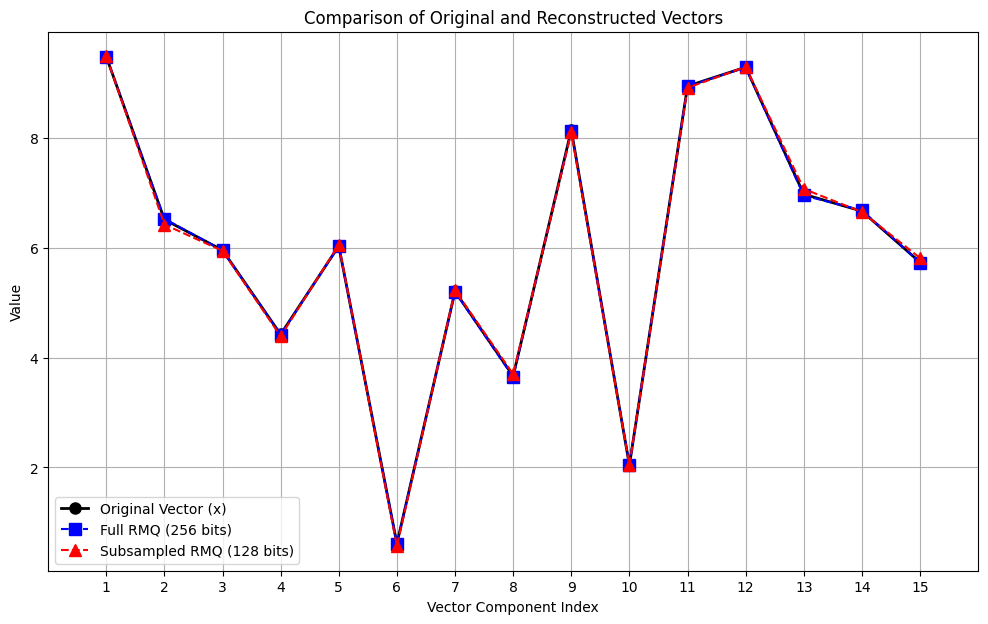

In [5]:
# =============================================================================
# VISUALIZATION
# =============================================================================
num_components_to_plot = 15

plt.figure(figsize=(12, 7))
plt.plot(range(1, num_components_to_plot + 1), x_vec[:num_components_to_plot],
         'k-o', linewidth=2, markersize=8, label='Original Vector (x)')
plt.plot(range(1, num_components_to_plot + 1), x_reconstructed[:num_components_to_plot],
         'b--s', linewidth=1.5, markersize=8, label=f'Full RMQ ({d*math.log2(k):.0f} bits)')
plt.plot(range(1, num_components_to_plot + 1), x_reconstructed_sub[:num_components_to_plot],
         'r--^', linewidth=1.5, markersize=8, label=f'Subsampled RMQ ({r} bits)')

plt.title('Comparison of Original and Reconstructed Vectors')
plt.xlabel('Vector Component Index')
plt.ylabel('Value')
plt.xticks(range(1, num_components_to_plot + 1))
plt.grid(True)
plt.legend(loc='best')
plt.xlim(0, num_components_to_plot + 1)
plt.show()